## Кейс

Рекламодатель Сигма жалуется на постоянный рост CPA по своим рекламным кампаниям в последние 4 месяца (с июня по сент 2022). Ваша задача проанализировать его размещение с целью:  
1) Выяснить причину растущего CPA  
2) Дать рекомендации по снижению и стабилизации CPA до целевого значения (380 руб) 

## Описание столбцов таблицы

Device – тип устройства  
Place – тип площадки (только для Type: Direct)  
BannerType – тип объявления  
QueryType – тип запроса (только для Type: Direct , только поиск)  
TargetingType – тип таргетинга (только для Type: Direct)  
Cost - расходы рекламодателя  
Conversions – целевые визиты (только Директ) 

Для начала хотелось бы получить ответы на следующие вопросы. 
Какой канал рассматриваем? 
Были ли какие-нибудь изменения в структуре маркетинговых расходов? 

## Чтение и обработка данных

Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import f_oneway
import seaborn as sns

Загрузка файла

In [2]:
df = pd.read_csv('data1.csv', sep=";")

Предварительное знакомство с данными

In [35]:
df.head()

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions,CPA
0,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.000000,0,NaN
1,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Retargeting,5949,41,1666.844364,0,NaN
2,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,cpc_video,none,Retargeting,191,6,40.641915,0,NaN
3,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,227,1,45.747407,0,NaN
4,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,18,0,0.000000,0,NaN


Просмотр типов данных

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   10478 non-null  object        
 1   Month                    10478 non-null  datetime64[ns]
 2   Category                 10478 non-null  object        
 3   Device                   10478 non-null  object        
 4   Place                    10478 non-null  object        
 5   BannerType               10478 non-null  object        
 6   QueryType (search only)  10478 non-null  object        
 7   TargetingType            10478 non-null  object        
 8   Shows                    10478 non-null  int64         
 9   Clicks                   10478 non-null  int64         
 10  Cost                     10478 non-null  float64       
 11  Conversions              10478 non-null  int64         
 12  CPA                      5932 no

<div class="alert alert-info">
<font size="5"><b>Замечание</b></font>  
    
Столбец Month имеет тип object. 
Стоит поменять его на datetime для удобства работы.
</div>

In [5]:
df['Month'] = pd.to_datetime(df['Month'], format='%m/%d/%y')

Посмотрим на количество категорий в столбцах

In [7]:
col = df.columns
for i in col:
    print(df[i].value_counts())

Псилон    2186
Сигма     1560
Гамма     1446
Зета      1371
Бета      1141
Омега      927
Альфа      894
Дельта     373
Лямбда     350
Мета       230
Name: Client, dtype: int64
2022-08-01    706
2022-07-01    662
2022-09-01    619
2022-06-01    610
2021-11-01    606
2021-12-01    599
2022-03-01    592
2021-10-01    587
2021-07-01    577
2021-09-01    572
2021-08-01    571
2021-05-01    550
2022-02-01    549
2022-05-01    544
2022-01-01    543
2021-06-01    538
2021-04-01    534
2022-04-01    519
Name: Month, dtype: int64
ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ      2595
РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ    1885
КРЕДИТНЫЕ КАРТЫ                   1805
ДЕБЕТОВЫЕ КАРТЫ                   1358
ВКЛАДЫ                            1223
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ            1174
ИНВЕСТИЦИИ                         438
Name: Category, dtype: int64
Desktop    5362
Mobile     5116
Name: Device, dtype: int64
Search      6070
Networks    4408
Name: Place, dtype: int64
text           6884
mcbanner       1407
image_ad    

Проверим даннные на наличие пропусков и дубликатов

In [8]:
df.isna().sum()

Client                     0
Month                      0
Category                   0
Device                     0
Place                      0
BannerType                 0
QueryType (search only)    0
TargetingType              0
Shows                      0
Clicks                     0
Cost                       0
Conversions                0
dtype: int64

In [9]:
df.duplicated().sum()

0

<div class="alert alert-info">
<font size="5"><b>Замечание</b></font>  
    
Столбец Cost имеет тип object. 
Стоит поменять его на float для удобства работы.
</div>

In [10]:
def convert_currency(val):
    new_val = val.replace(',', '.')
    return float(new_val)

In [11]:
df['Cost'] = df['Cost'].apply(convert_currency)

Добавим столбец CPA

In [13]:
df['CPA'] = df['Cost']/df['Conversions'].loc[df['Conversions'] != 0]

## Графический анализ данных

Посмотрим на поведение CPA у всех клиентов за имеющийся период времени

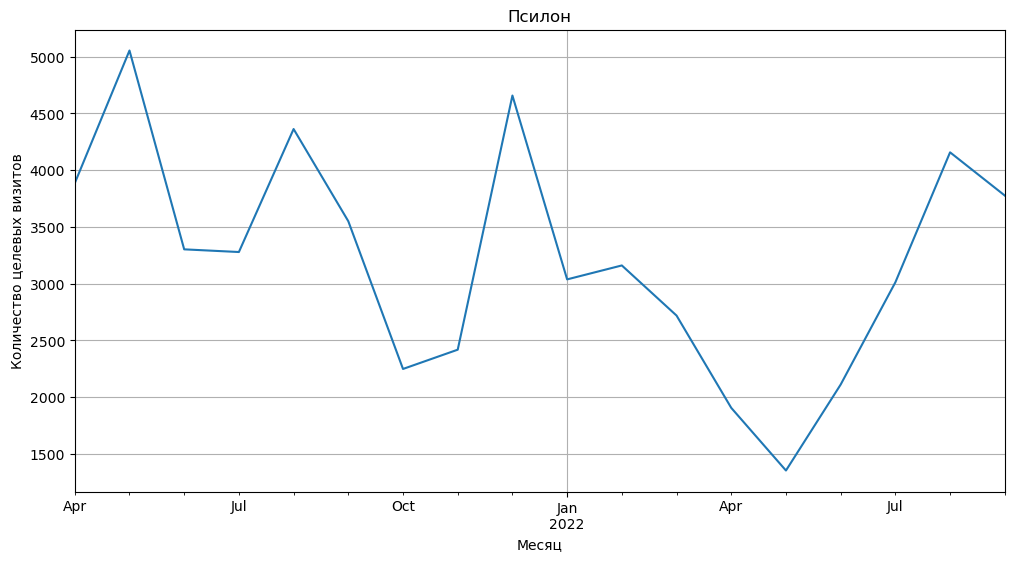

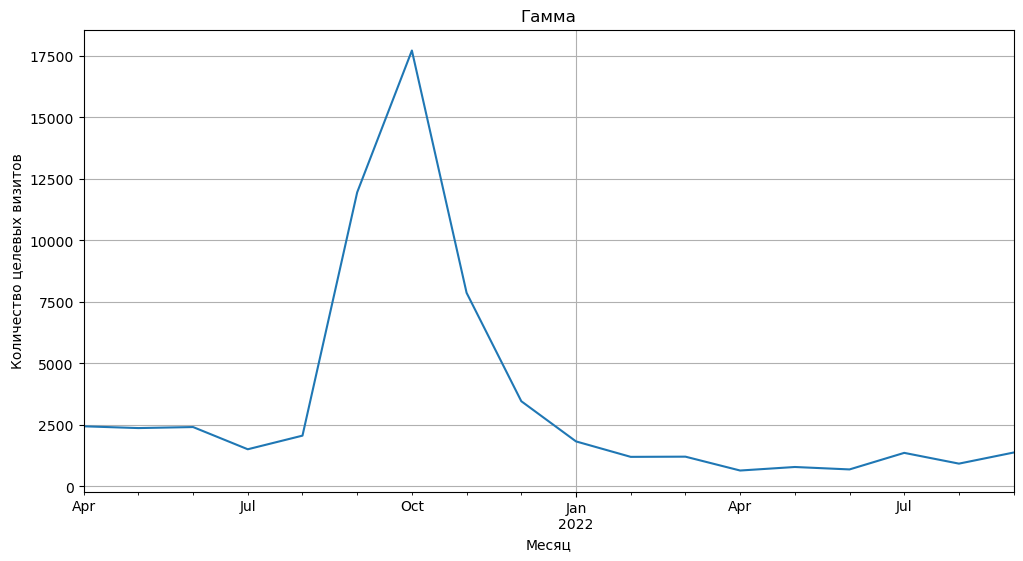

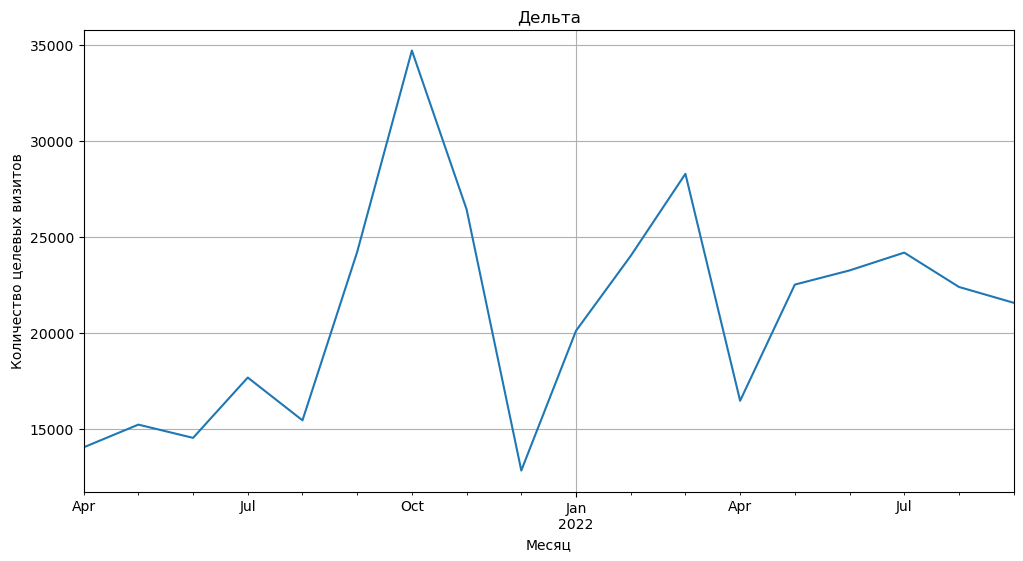

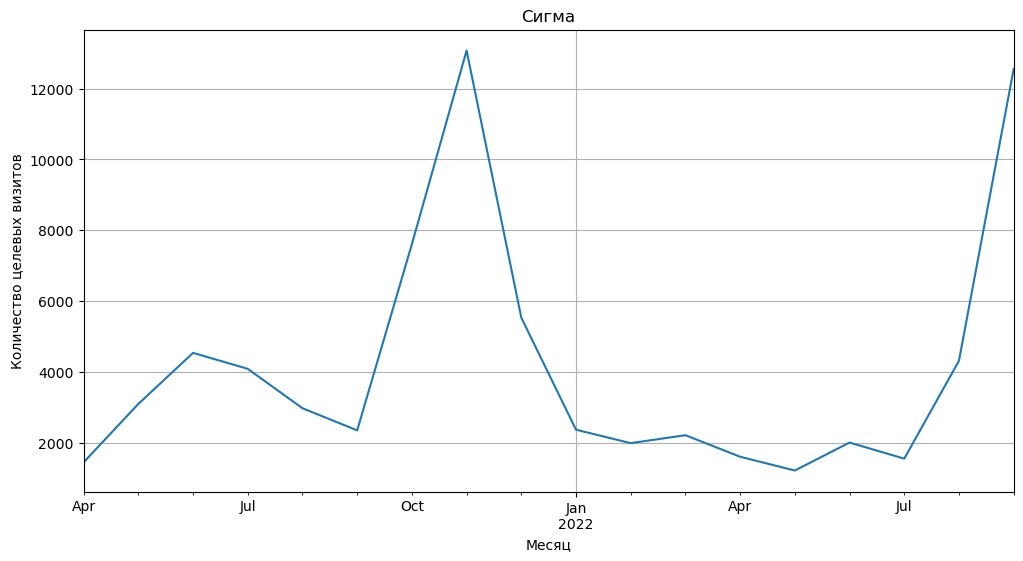

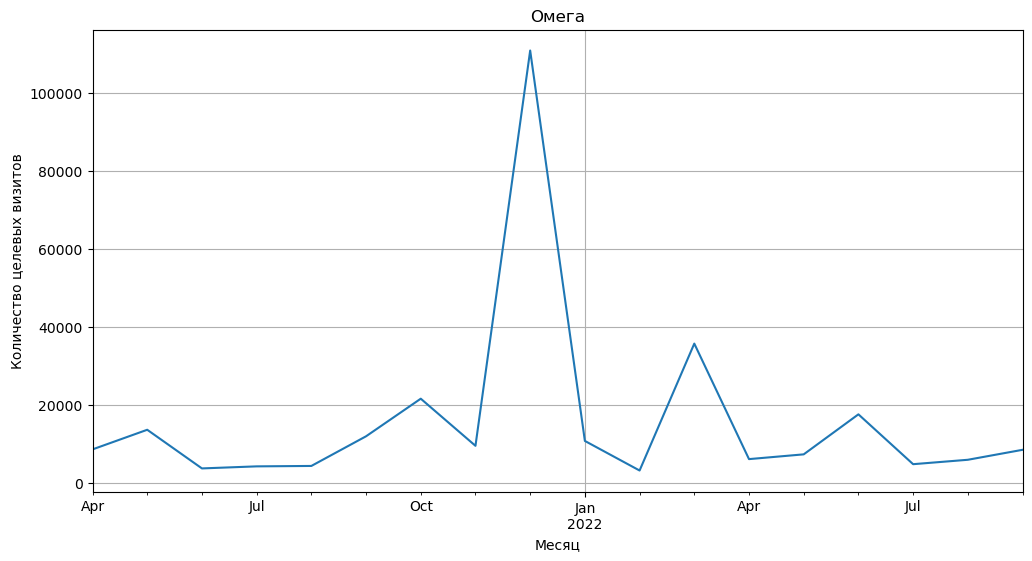

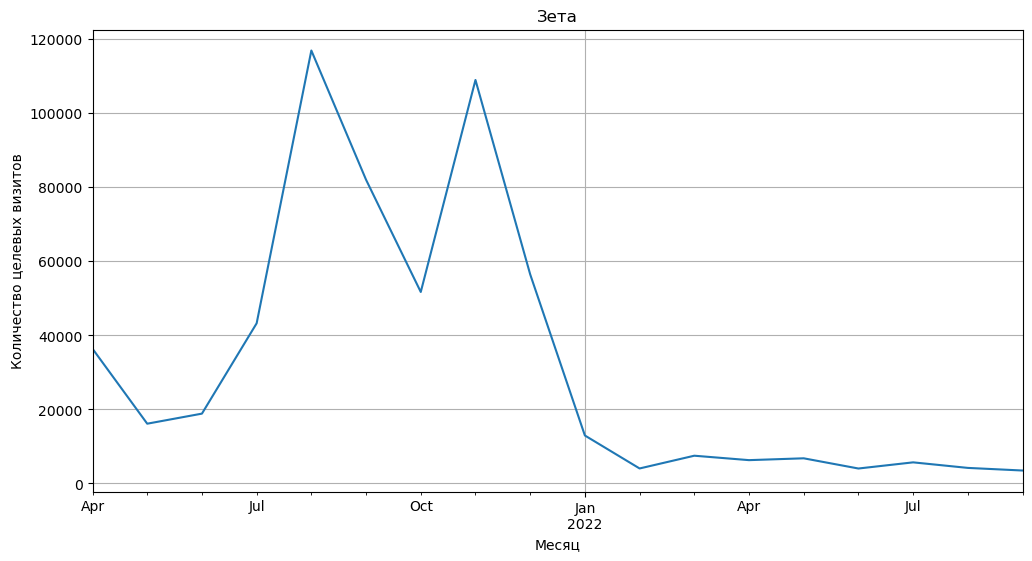

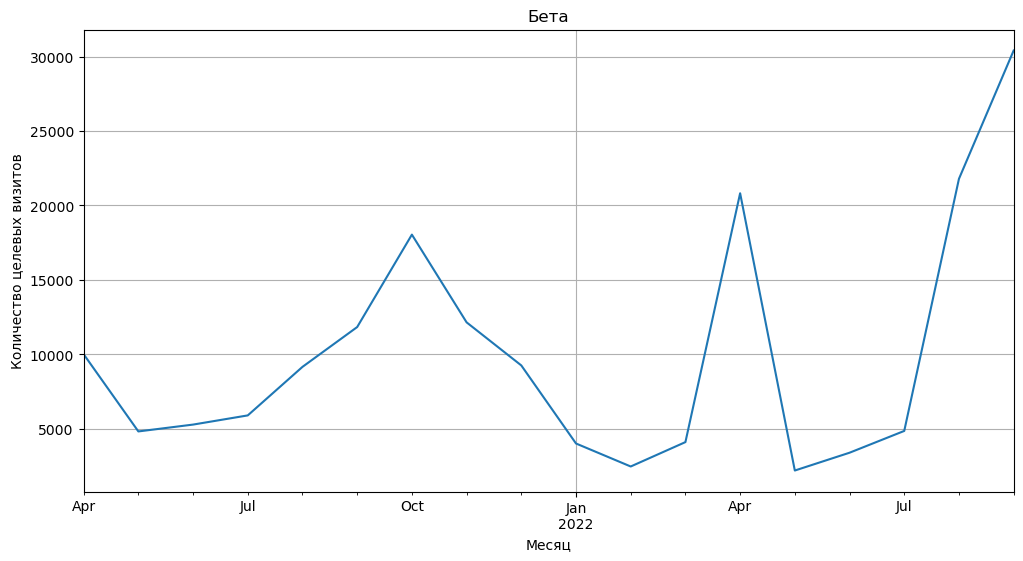

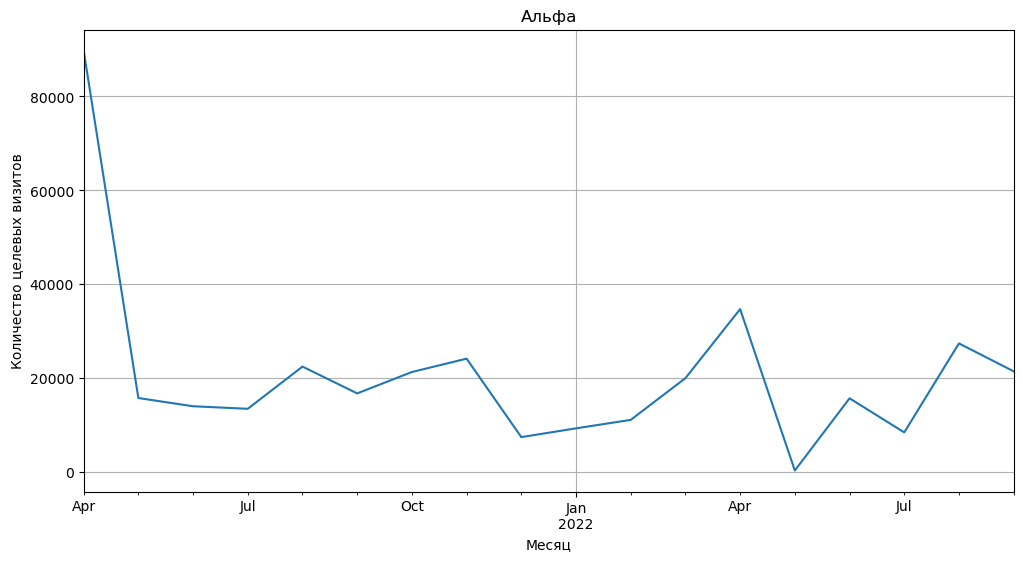

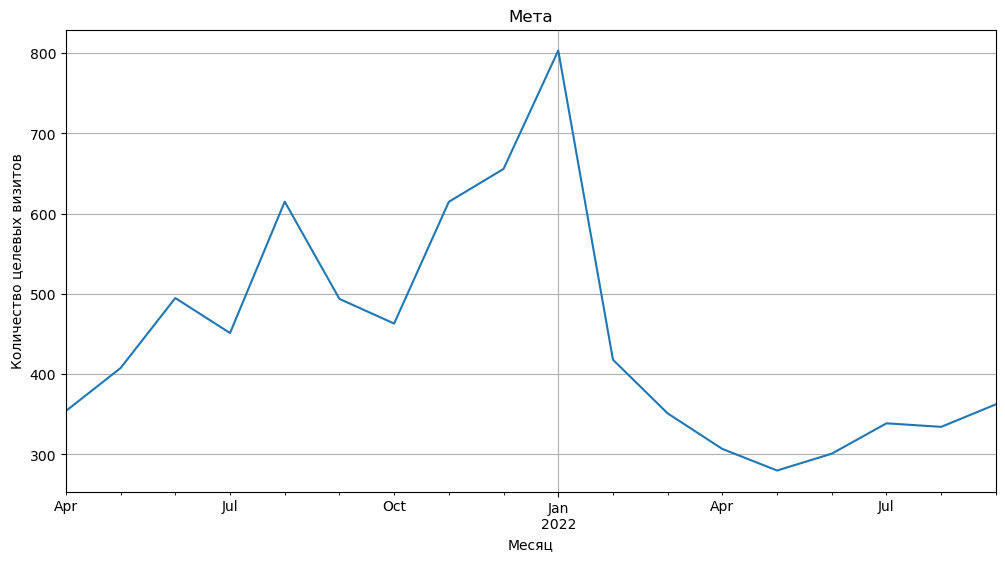

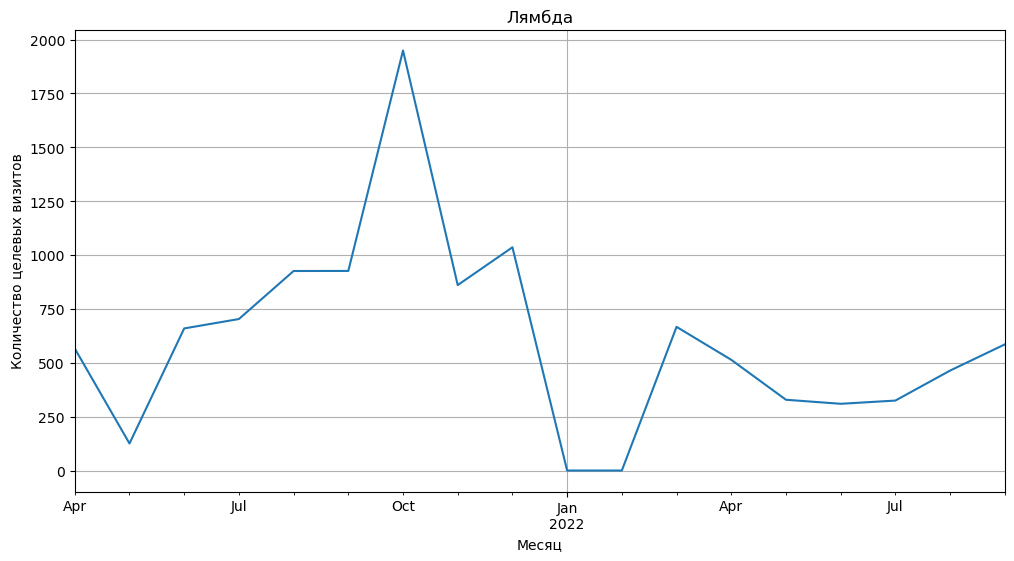

In [14]:
col = df['Client'].unique()
for i in col:
    df_by_date = df.loc[df['Client'] == i].pivot_table(index='Month', values='CPA')
    df_by_date.plot(title=i, xlabel='Месяц', ylabel='Количество целевых визитов', grid=True, legend=False, figsize=(12,6))

<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
На основе графиков можно сказать, что небольшой рост CPA виден у клиентов Лямбда, Мета и Омега. Но вот у клиентов Сигма и Бета наблюдается сильное возрастание данного показателя в схожий период времени. 
Как вариант, можно посмотреть, что именно обьединяет эти компании и на основании даных делать выводы о причинах роста. 
</div>

<AxesSubplot:title={'center':'CPA по компаниям'}, xlabel='Название компании', ylabel='CPA'>

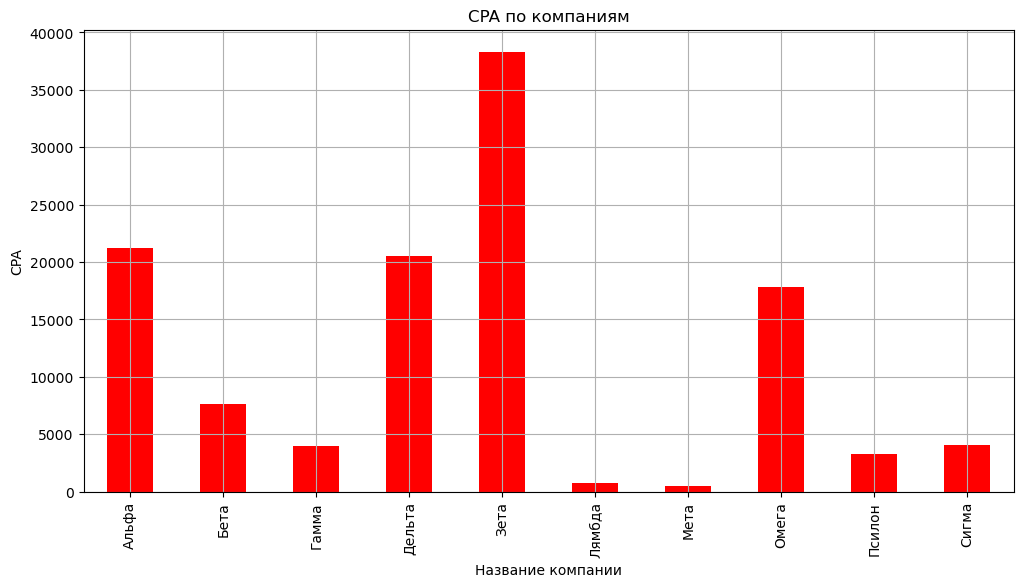

In [48]:
conv_clients = df.loc[df['Month'] < '2022-06-01'].pivot_table(index='Client', values='CPA')
conv_clients.plot(kind='bar', title='CPA по компаниям', xlabel='Название компании', ylabel='CPA', grid=True, legend=False, figsize=(12,6), color='r')

<AxesSubplot:title={'center':'CPA по компаниям за последние 4 месяца'}, xlabel='Название компании', ylabel='CPA'>

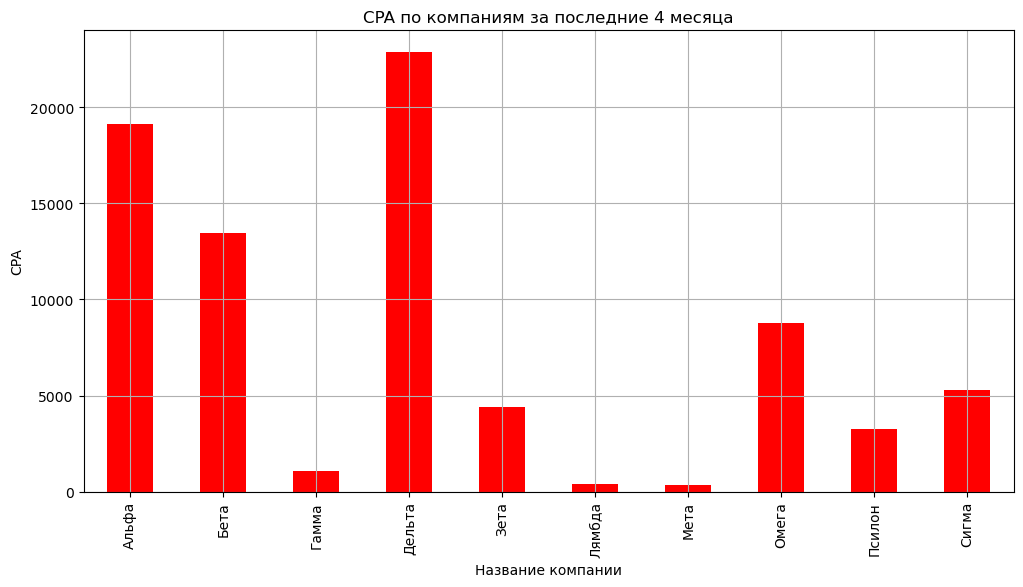

In [49]:
conv_clients = df.loc[df['Month'] >= '2022-06-01'].pivot_table(index='Client', values='CPA')
conv_clients.plot(kind='bar', title='CPA по компаниям за последние 4 месяца', xlabel='Название компании', ylabel='CPA', grid=True, legend=False, figsize=(12,6), color='r')

<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
Как видно наши "лидеры" (Сигма и Бета) по приросту CPA являются далеко не первыми по среднему значению среди остальных клиентов. Прирост CPA у Сигмы не сильно велик, относительно разбросов CPA у других клиентов. Дельте, напрмер, за последние месяца куда хуже. А вот Зета показывает отличные результаты со временем. 
</div>


## Статистический анализ

Посмотрим на срез данных клиента Сигма

In [16]:
df_sigma = df.loc[df['Client'] == 'Сигма']
df_sigma

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions,CPA
8,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,531,4,99.492000,0,NaN
9,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,215,2,52.658212,0,NaN
55,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,5053827,2531,74531.395042,0,NaN
56,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Retargeting,45630,50,1536.406424,0,NaN
57,Сигма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Search,text,Brand,Phrase,6933,1036,27636.633508,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10442,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Phrase,399500,7921,59133.506136,232,254.885802
10443,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Retargeting,47139,1132,4998.836542,31,161.252792
10444,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Search,text,Brand,Phrase,10590,2991,17404.488559,74,235.195791
10445,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Search,text,Competitor,Phrase,0,0,0.000000,0,NaN


Посмотрим на основные статистические характеристики данных

In [17]:
col = ['Category', 'Device', 'Place', 'BannerType',
       'QueryType (search only)', 'TargetingType']
for i in col:
    print(df_sigma.groupby(i)['CPA'].describe())

                                count          mean           std  min  \
Category                                                                 
ВКЛАДЫ                          139.0    123.870788    100.303607  0.0   
ДЕБЕТОВЫЕ КАРТЫ                 141.0   1535.530518   1438.346351  0.0   
ИНВЕСТИЦИИ                        0.0           NaN           NaN  NaN   
ИПОТЕЧНОЕ КРЕДИТОВАНИЕ          171.0   2093.460969   3022.566801  0.0   
КРЕДИТНЫЕ КАРТЫ                 161.0    307.991112    510.761684  0.0   
ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ    213.0    487.671367    678.812997  0.0   
РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ  202.0  18400.983358  45064.478024  0.0   

                                        25%          50%           75%  \
Category                                                                 
ВКЛАДЫ                            75.900966   112.712942    148.091881   
ДЕБЕТОВЫЕ КАРТЫ                  316.056549  1224.284814   2313.716125   
ИНВЕСТИЦИИ                           

<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
*Category*  
КРЕДИТНЫЕ КАРТЫ (161 размещение) и ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ (213 размещений) показывают лучшие результаты по CPA, а  РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ (202 размещения) выдает среднее CPA в 18400.  

*Device*  
Desktop показывает среднее CPA в 3544, со стандартным отклонением в 9922, а вот у Mobile теже характеристики выше 5124 и 28102, что говорит нам о преимуществе Mobile перед Desktop относительно рамера CPA.    

*Place*  
Networks уступает тут Search почти в два раза относительно CPA, но и замечу что у второго тут размещений в два раза больше, что говорит нам о том, что маркетологи идут/шли в верном направлении.   

*BannerType*  
Тут все в порядке. Больше всего размещений у text и он же обладает самым низким показателем из представленных.    

*QueryType (search only)*  
Здесь больше всего размещений у none,хотя у него самые высокие показатели CPA из всех. Но видно, что маркетологи пробовали все варианты практически равновероятно. Лидером тут является Brand.   

*TargetingType*  
Больше всего размещений у Phrase с не самыми плохими показателями. Но я бы отдала предпочтение относительно CPA в пользу Autotargeting и посмотрела бы на результаты со временем. Вероятно выбор Phrase был чем то обоснован все таки. 
</div>


Оставим данные только за 2022 год и те строки, где вносились деньги за рекламу.

In [53]:
df_sigma_2022 = df_sigma.loc[(df_sigma['Month'].dt.year == 2022) & (df_sigma['Cost'] != 0)]

In [54]:
df_sigma_2022

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions,CPA
920,Сигма,2022-01-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Phrase,997434,1598,23919.711025,10,2391.971103
921,Сигма,2022-01-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,474378,446,16674.928754,1,16674.928754
922,Сигма,2022-01-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,2152820,26200,107257.943161,7,15322.563309
923,Сигма,2022-01-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,330678,2325,26800.763415,0,NaN
960,Сигма,2022-01-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,text,none,Phrase,50200764,34627,881553.572339,120,7346.279769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10440,Сигма,2022-09-01,ВКЛАДЫ,Desktop,Search,text,Brand,Phrase,1003,214,2745.924153,8,343.240519
10442,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Phrase,399500,7921,59133.506136,232,254.885802
10443,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Networks,text,none,Retargeting,47139,1132,4998.836542,31,161.252792
10444,Сигма,2022-09-01,ВКЛАДЫ,Mobile,Search,text,Brand,Phrase,10590,2991,17404.488559,74,235.195791


Посмотрим куда вкладывались деньги

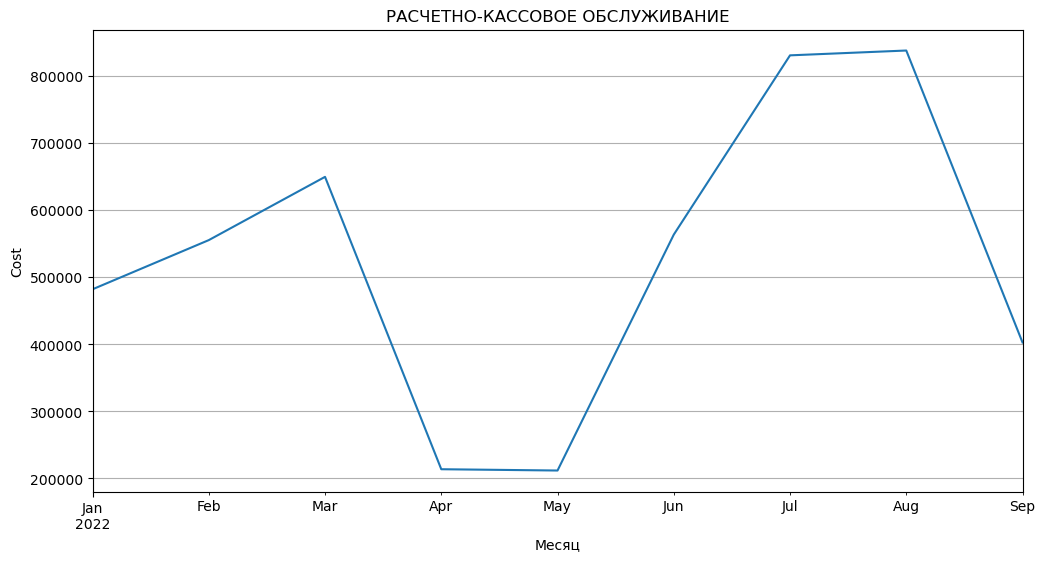

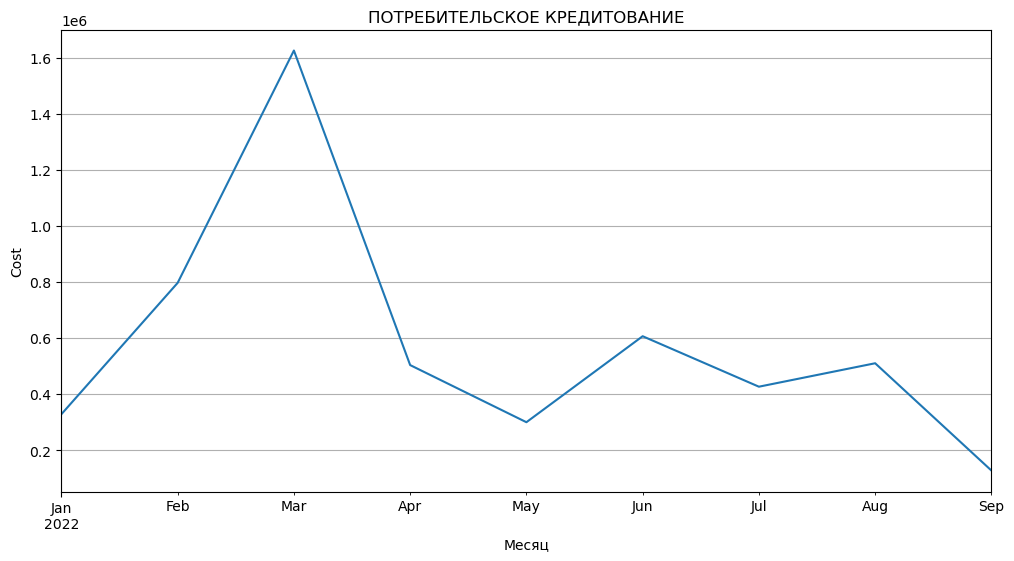

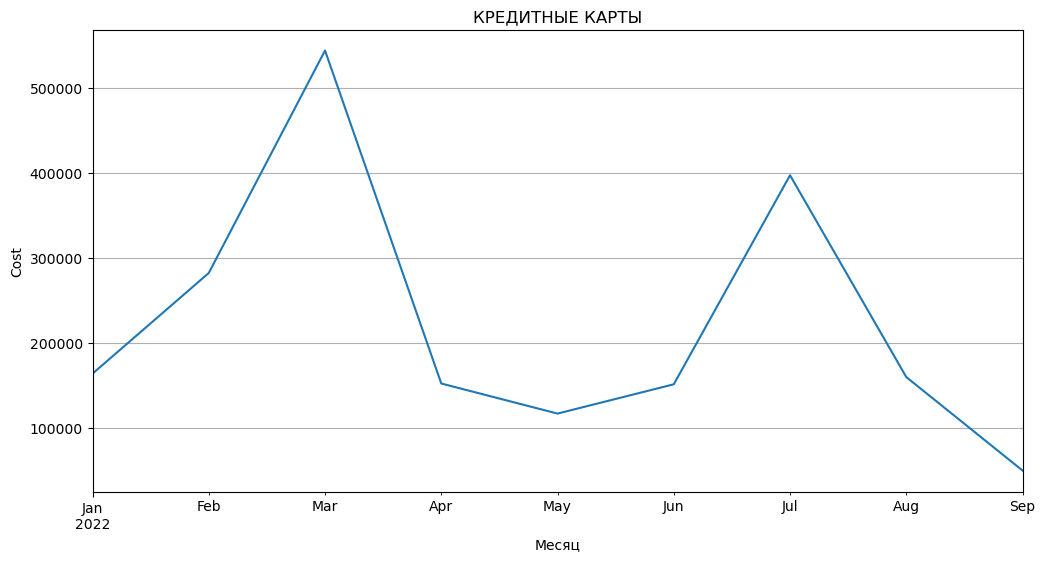

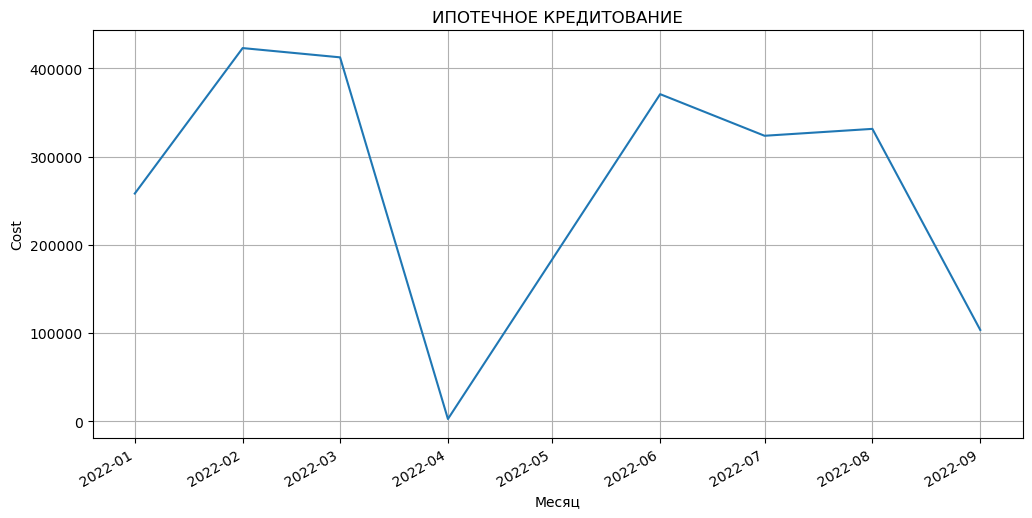

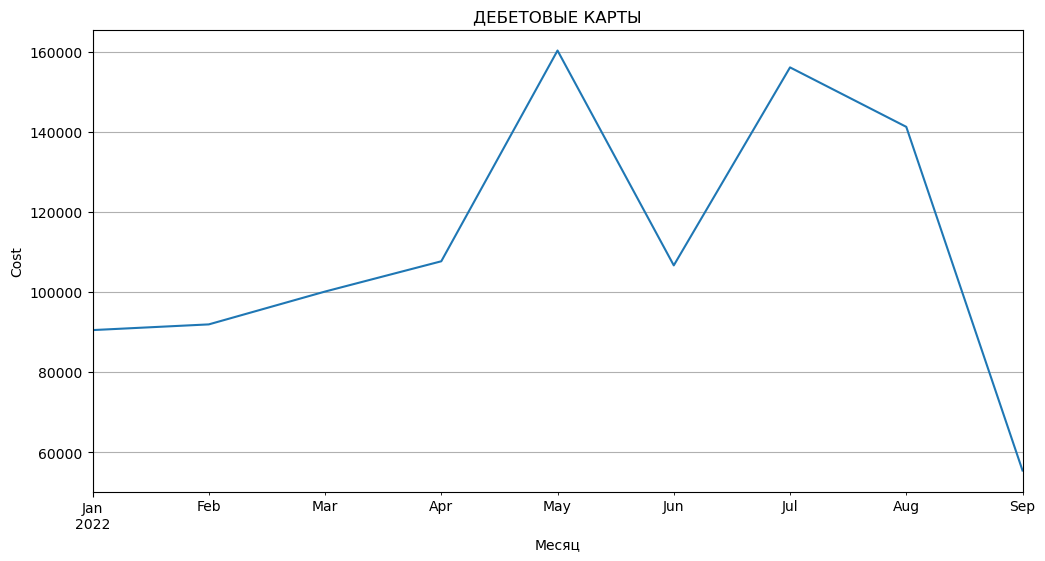

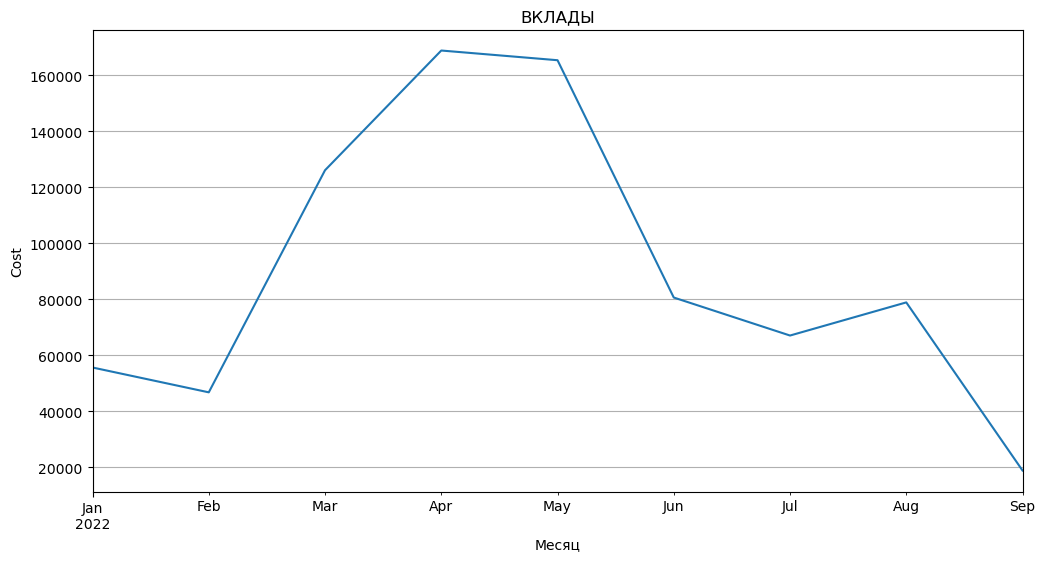

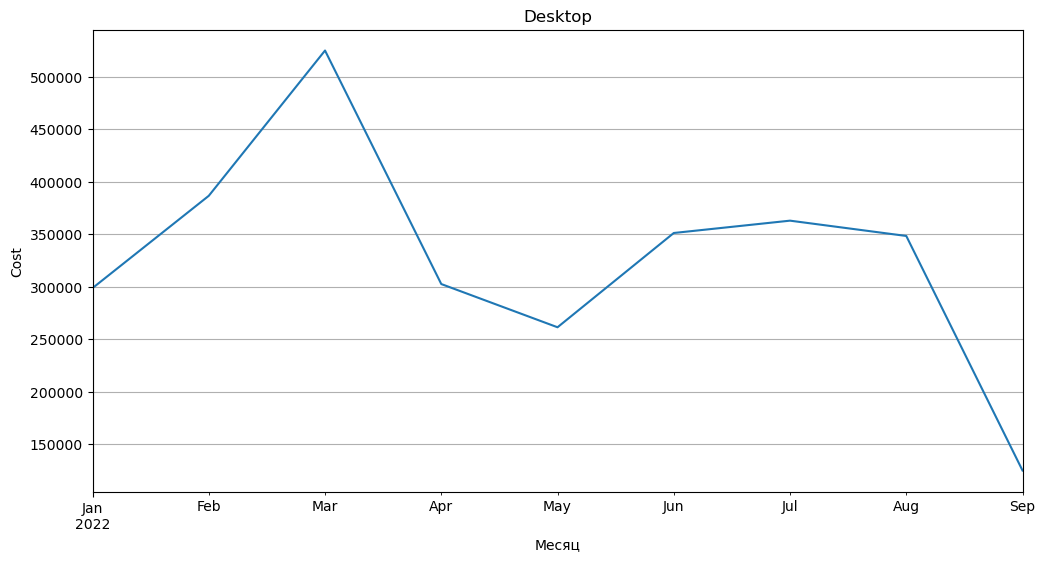

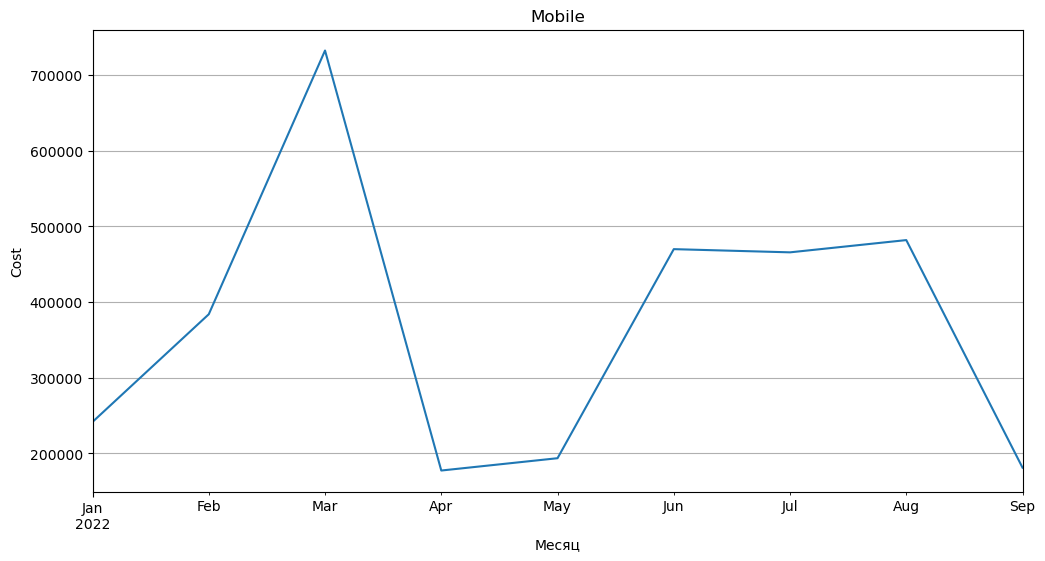

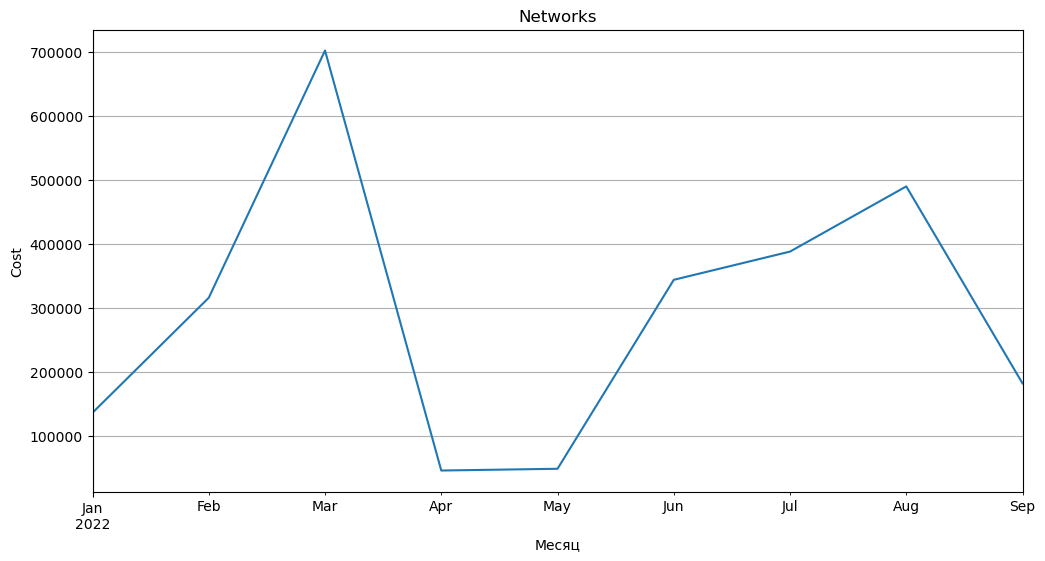

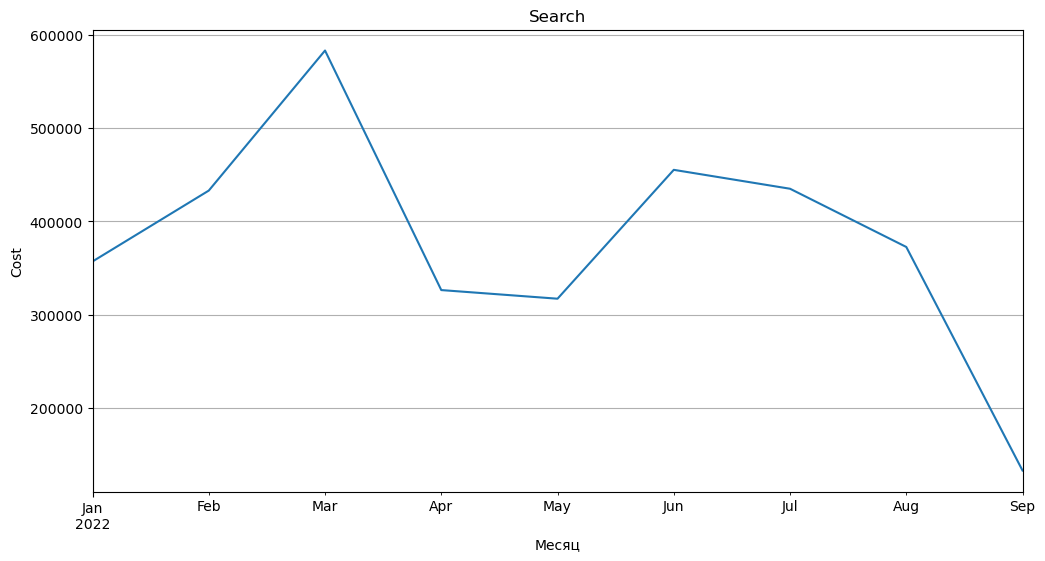

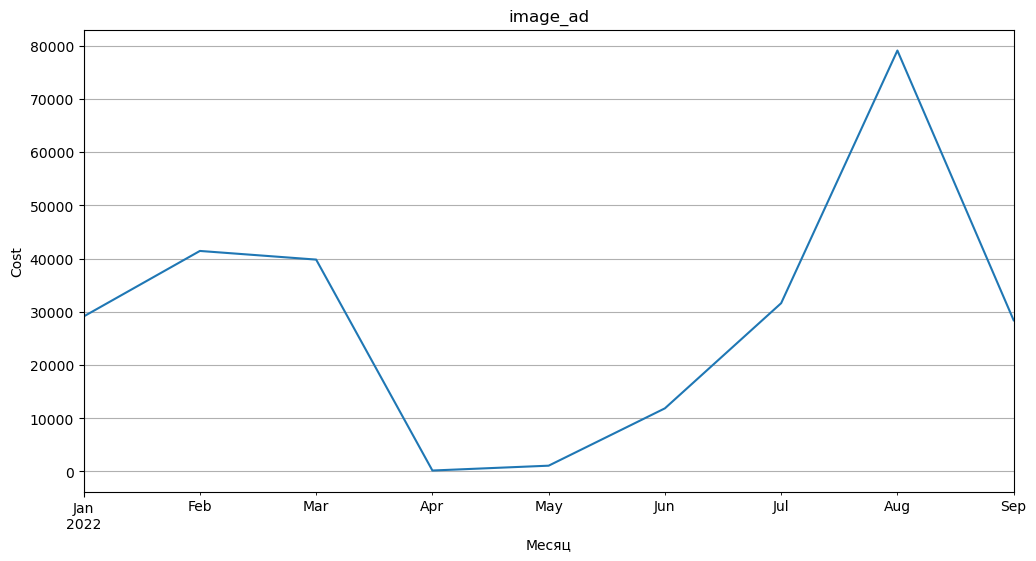

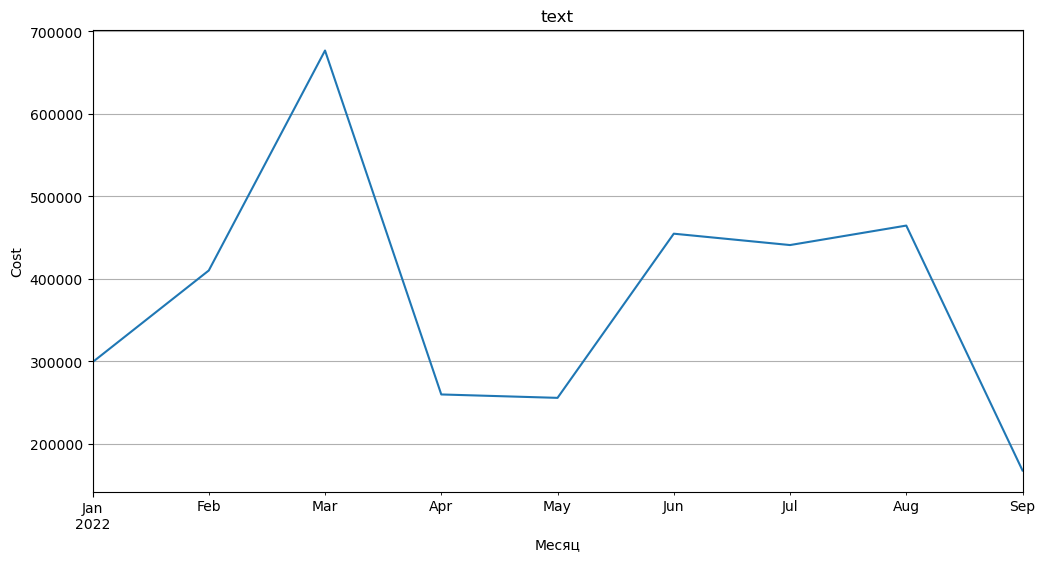

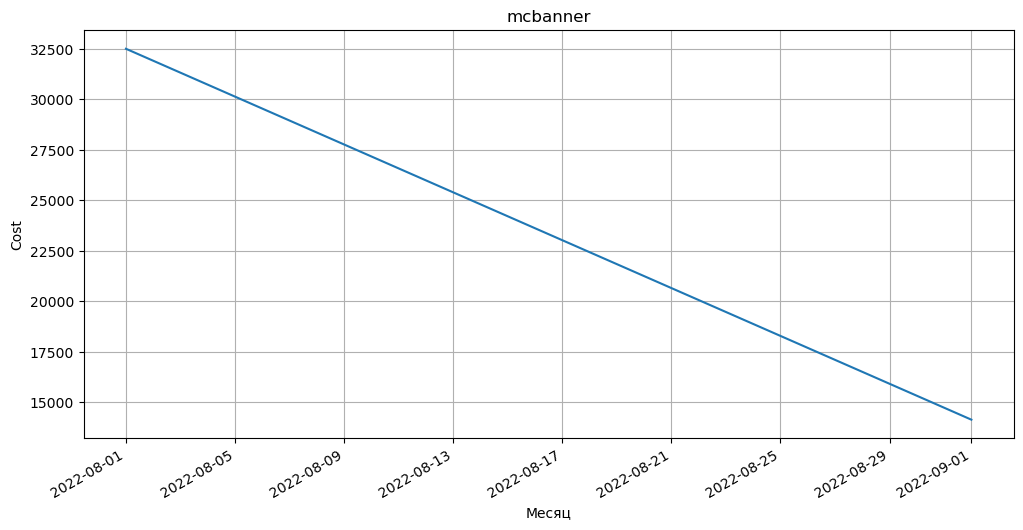

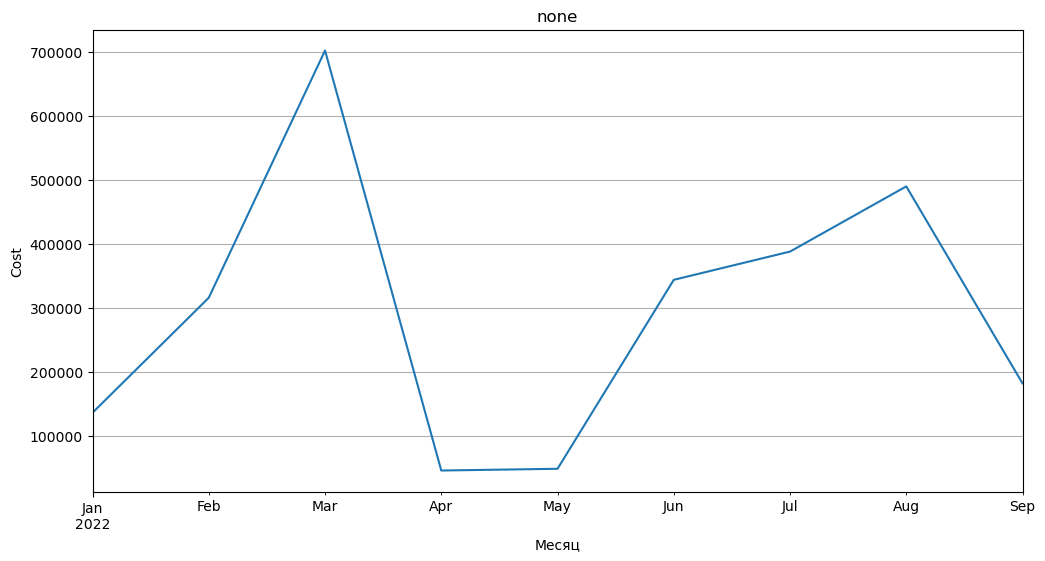

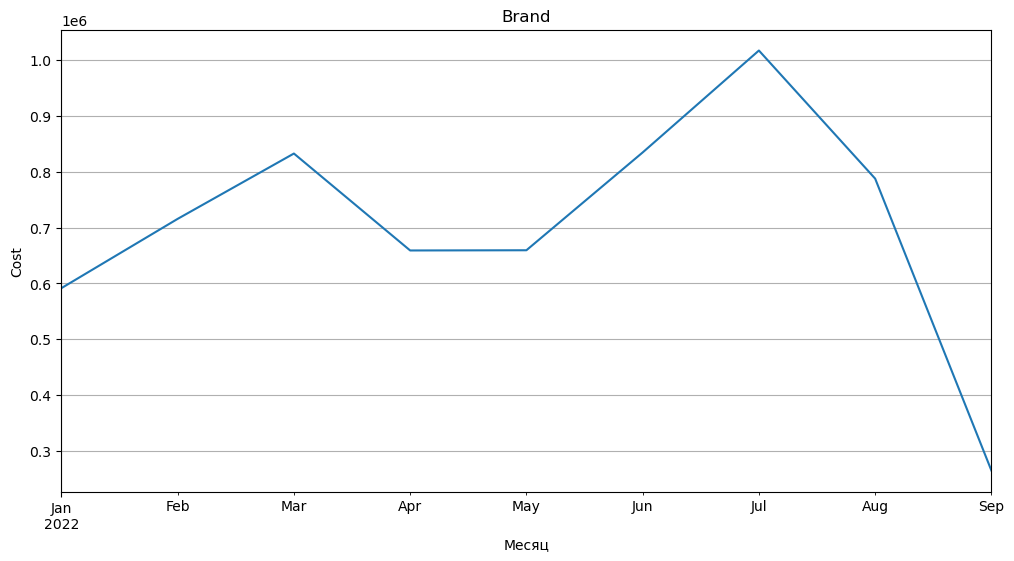

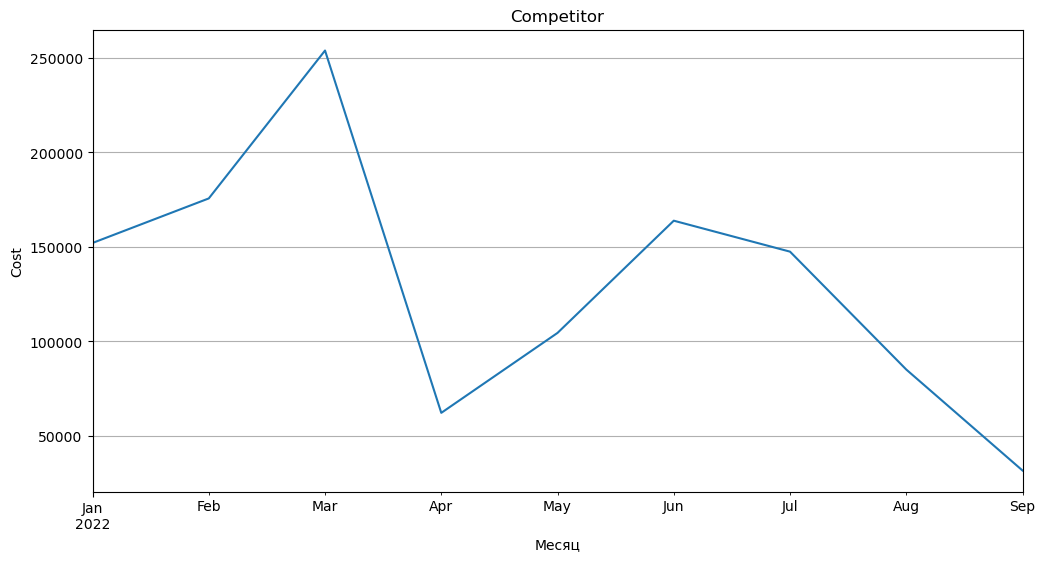

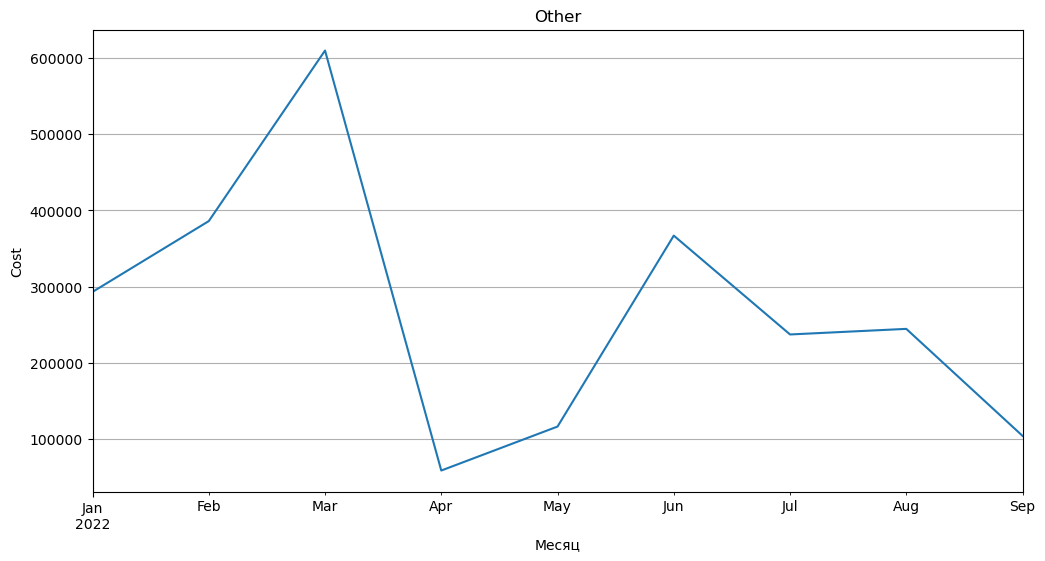

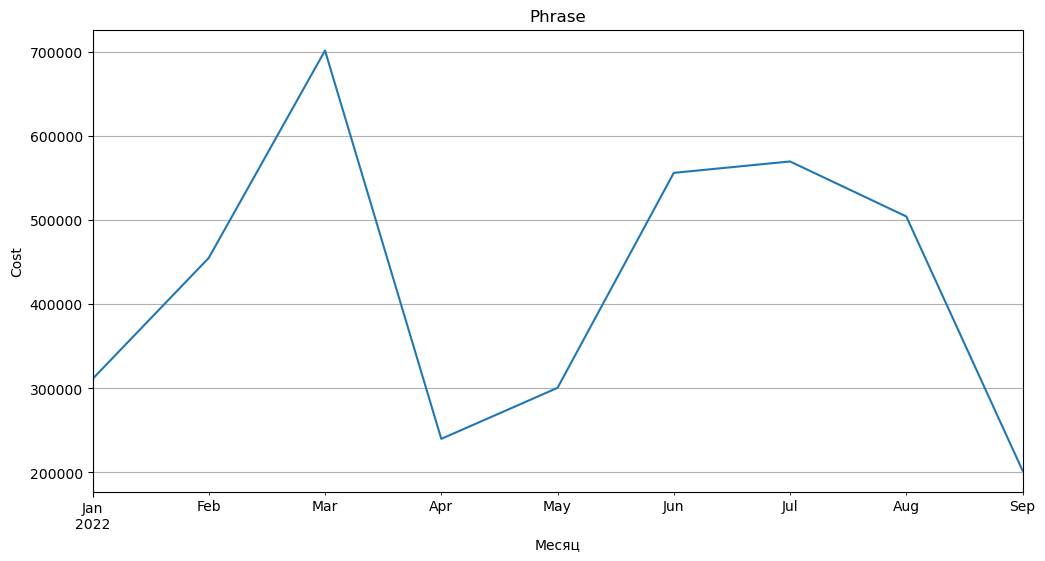

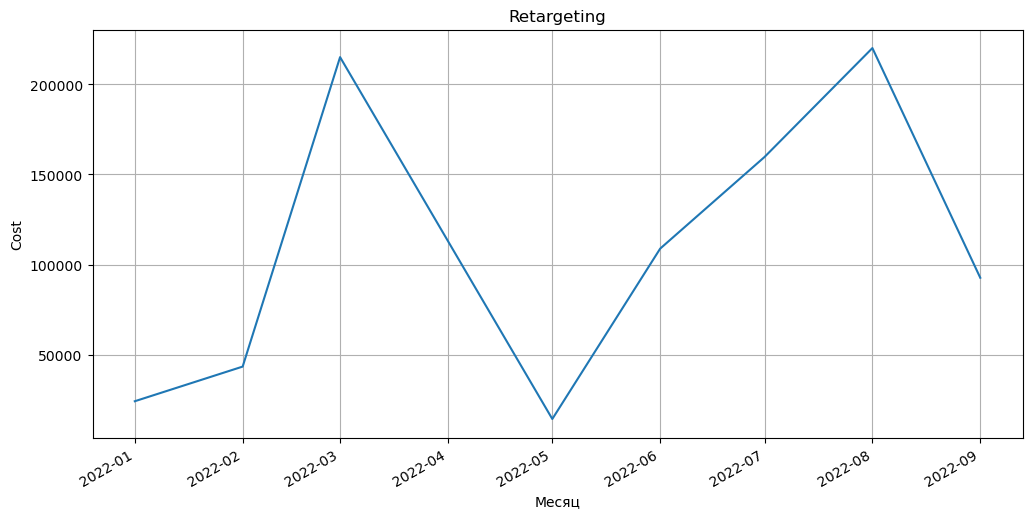

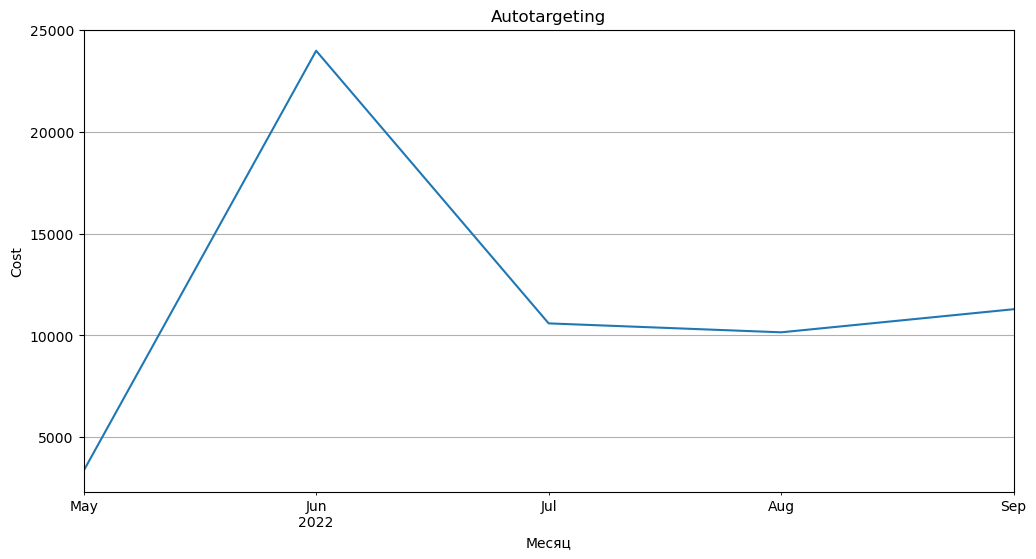

In [59]:
col = ['Category', 'Device', 'Place', 'BannerType',
       'QueryType (search only)', 'TargetingType']
cat = df_sigma_2022['Category'].unique()
for j in col:
    cat = df_sigma_2022[j].unique()
    for i in cat:
        df_by_date = df_sigma_2022.loc[df_sigma_2022[j] == i].pivot_table(index='Month', values='Cost')
        df_by_date.plot(title=i, xlabel='Месяц', ylabel='Cost', grid=True, legend=False, figsize=(12,6))

<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
Никаких сильных изменений в структуре маркетинговых расходов пока не вижу. Видно, что финансирование упало во всех категориях. 
</div> 

Взглянем на корреляцию численных данных. Имеет это смысл? Нет. Тогда зачем? Просто так:)

In [23]:
df_sigma_2022.corr()

,Shows,Clicks,Cost,Conversions,CPA
Shows,1.000000,0.520568,0.489461,0.072622,0.080760
Clicks,0.520568,1.000000,0.860342,0.634926,0.085472
Cost,0.489461,0.860342,1.000000,0.601377,0.140544
Conversions,0.072622,0.634926,0.601377,1.000000,-0.066428
CPA,0.080760,0.085472,0.140544,-0.066428,1.000000


Попробуем провести статистический тест. Для определения зависимости категориальный признак - числовой признак воспользуемся ANOVA.

Нулевая гипотеза(H0): Признаки не коррелируют между собой.  
Гипотиза подтверждается только тогда, когда P-Value > 0,05

In [24]:
df_sigma_2022_not_nan = df_sigma_2022.dropna(subset='CPA')

In [25]:
col = ['Category', 'Device', 'Place', 'BannerType',
       'QueryType (search only)', 'TargetingType']
for i in col:
    print(i)
    CategoryGroupLists=df_sigma_2022_not_nan.groupby(i)['CPA'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    print('P-Value for Anova is: ', AnovaResults[1])

Category
P-Value for Anova is:  8.199045739277011e-06
Device
P-Value for Anova is:  0.17241528888519572
Place
P-Value for Anova is:  0.03229983918511841
BannerType
P-Value for Anova is:  0.0652143919968852
QueryType (search only)
P-Value for Anova is:  0.17786995093828956
TargetingType
P-Value for Anova is:  0.08348606916335573


<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
Гипотеза была отвергнута для категорий Category и Place. На них стоит обратить особое внимание. 
Если сопоставить эти данные и графики вложенных в рекламу денег, то можно заметить что за "тот самый период в 4 месяца" увеличелись финансирование на категорию Networks, что и могло привести к росту CPA. 
Тоже самое можно сказать и о РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ из Category. Финансирование этой категории увеличелось за данный период.  
</div> 

Взглянем на зависимость CPA и Category на промежутке времени

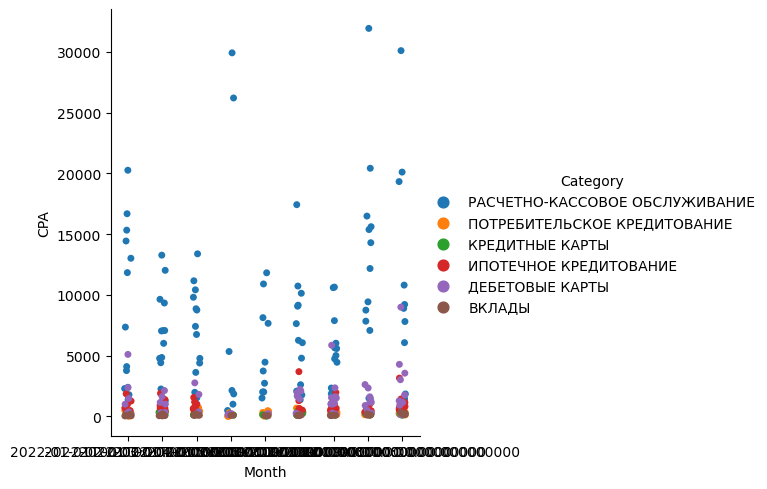

In [61]:
sns.catplot(data=df_sigma_2022.loc[df_sigma_2022['CPA'] < 50000], x='Month', y='CPA', hue="Category")

Посмотрим на 𝜙k корреляционную матрицу

interval columns not set, guessing: ['Shows', 'Clicks', 'Cost', 'Conversions', 'CPA']


/opt/anaconda3/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Client for analysis 1. Dropping this column
  warnings.warn(


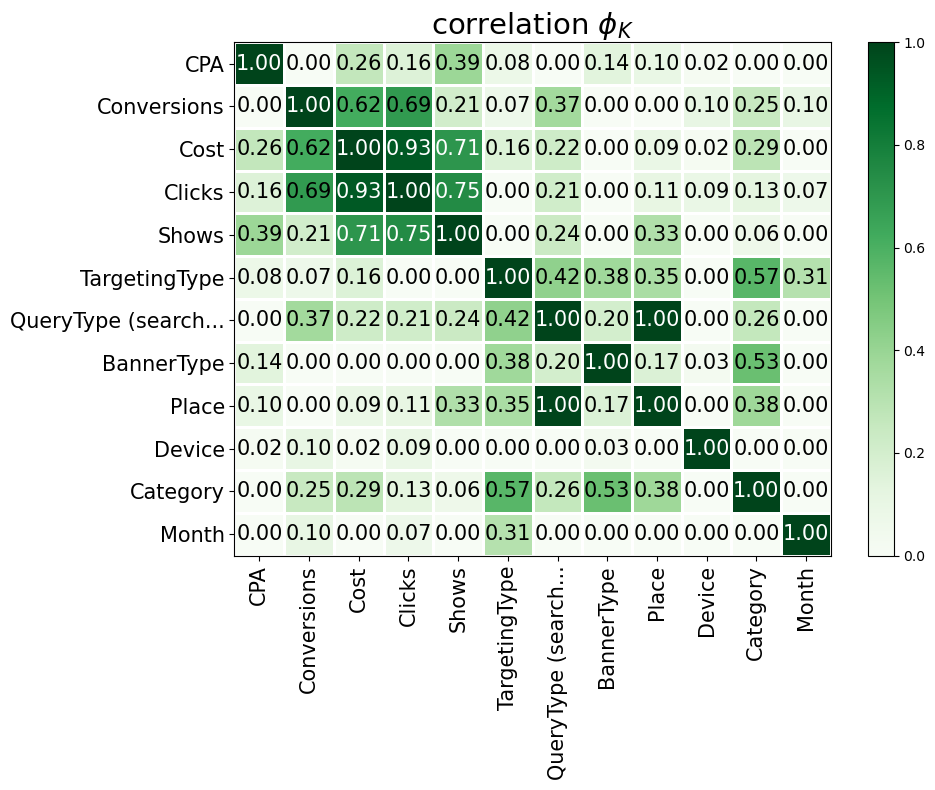

In [26]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = df_sigma_2022_not_nan.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

<div class="alert alert-info">
<font size="5"><b>Вывод</b></font>  
    
Этот метод выявил небольшую коррелляцию CPA и BannerType.   
Если снова обратиться к графику расходов на категориях, то можно заметить, что в данный период были увеличены разсходы на image_ad (не с самыми лучшими показателями CPA), а на text были снижены.
</div> 

<div class="alert alert-warning">
<font size="5"><b>Общий вывод</b></font>

<b>Причина роста CPA:</b>   
    изменение в структуре маркетинговых расходов (финансирование в "неликвидные" категории, которые повышают CPA), а именно 
- увеличено финансирование пункта РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ из Category;
- увеличено финансирование пункта Networks из Place;
- увеличено финансирование пункта image_ad из BannerType;
- снижено финансирование пункта text из BannerType. 

<b>Рекомендации для снижения и стабилизации CPA:</b>  
 - размещение рекламы в следующих категориях:  
    
*Category*  
КРЕДИТНЫЕ КАРТЫ и ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ показывают лучшие результаты по CPA.  

*Device*  
Desktop показывает среднее CPA в 3544, со стандартным отклонением в 9922, а вот у Mobile теже характеристики выше 5124 и 28102, что говорит нам о преимуществе Mobile перед Desktop относительно рамера CPA.    

*Place*  
Networks уступает Search почти в два раза относительно CPA. 

*BannerType*  
Лучше отдать предпочтение text, так как он обладает самым низким показателем из представленных.    

*QueryType (search only)*  
Здесь лучше вкладываться в Brand или Other. Категория none слишком сильно влияет на повышение CPA.

*TargetingType*  
Больше всего размещений у Phrase с не самыми плохими показателями. Но я бы отдала предпочтение относительно CPA в пользу Autotargeting и посмотрела бы на результаты со временем.     
      
    
   
<b>Общие рекомендации:</b>  
1. Тексты
- придумываем уникальное товарное предложение (предложения в объявлении и на сайте должны совпадать);
- добавляем в объявления все доступные элементы (быстрые ссылки, виртуальную визитку).
2. Запросы
- добавляем минус-слова;
- выделяем вложенные запросы;
- удаляем нецелевые и дублирующие запросы, пересечения фраз.
3. Сайт
- проверяем, насколько он удобен (быстрый поиск, доступность информации о цене и доставке);
- проверяем работоспособность (работает ли поиск, форма заявки);
- выбираем максимально релевантную посадочную страницу, которая соответствует информации в тексте объявления.
4. Настройки кампании
- разделяем кампании на поиск и сети, по регионам;
- тестируем автостратегию «Оптимизация конверсий»;
- подбираем таргетинги: настраиваем рекламу на релевантную целевую аудиторию (ретаргетинг, сегменты аудитории).
